<a href="https://colab.research.google.com/github/melihkurtaran/MachineLearning/blob/main/InstanceBasedLearning/InstancebasedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instance-based Learning Project**

In [1]:
!pip install cvxpy # download cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Import Libraries
import numpy as np
import pandas as pd
from sklearn import svm
import cvxpy as cp
from cvxopt import matrix, solvers
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

In [3]:
#Connect to GitHub for faster access
!git clone https://github.com/melihkurtaran/MachineLearning.git

fatal: destination path 'MachineLearning' already exists and is not an empty directory.


My group number is 9

In [4]:
#Reading the files

#for task 1
ds1 = pd.read_csv('MachineLearning/InstanceBasedLearning/ds091.txt', sep=" ", header=None, index_col=False, skiprows=1)

#for task 2
ds2 = pd.read_csv('MachineLearning/InstanceBasedLearning/ds092.txt', sep=" ", header=None, index_col=False, skiprows=1)

#for task 3
ds3tr = pd.read_csv('MachineLearning/InstanceBasedLearning/ds093tr.txt', sep=" ", header=None, index_col=False, skiprows=1)
ds3te = pd.read_csv('MachineLearning/InstanceBasedLearning/ds093te.txt', sep=" ", header=None, index_col=False, skiprows=1)

# **T1**

In [5]:
ds1.loc[ds1[2] == 0, 2] = -1

In [6]:
# Load the data and labels
X = ds1[[0,1]].values
y = ds1[2].values

In [7]:
# Class 0 are negatives and Class 1 are positives
class_0 = ds1.loc[ds1[2] == -1]
class_1 = ds1.loc[ds1[2] == 1]

class_0

,0,1,2
0,-2.131739,0.675048,-1.0
1,-5.656211,-0.085275,-1.0
2,1.350096,4.263477,-1.0
3,-3.567110,2.067782,-1.0
4,-0.781642,4.938526,-1.0
5,-4.938526,-0.781642,-1.0
6,-2.153058,2.089101,-1.0
7,-3.545792,0.653729,-1.0


In [8]:
class_0 = class_0.to_numpy()
class_1 = class_1.to_numpy()

Plot the samples

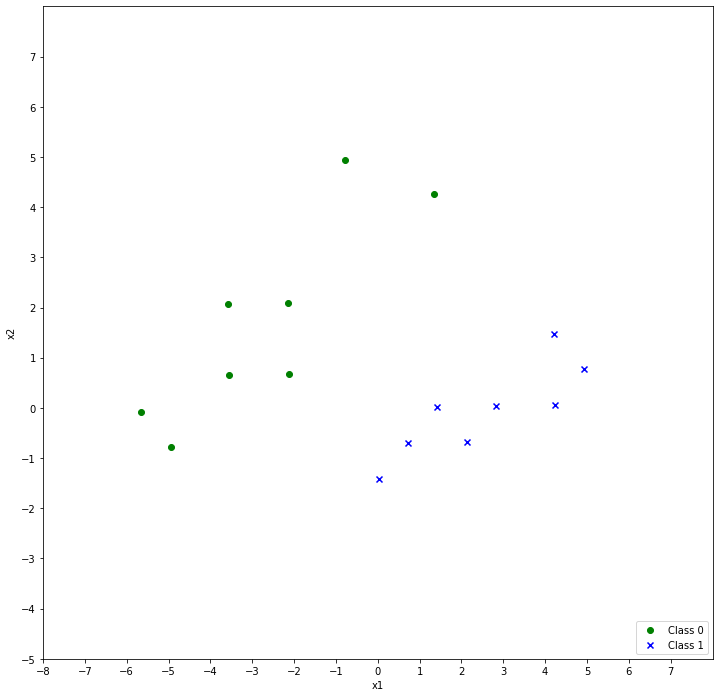

In [9]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-5, 8)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-5, 8, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


## **a) Solve for the SVM with quadratic programming solver**

In [10]:
# N is the number of rows in the data matrix X
N = X.shape[0]

# Reshape y to match the shape of X
y = y.reshape((N,1))

# Create variables for the weights and bias
w = cp.Variable((2,1))
w0 = cp.Variable()

# Define the loss function as the L2 norm of w squared, which is equivalent to the L2 regularization
loss = cp.Minimize(0.5 * cp.square(cp.norm(w)))

# Create an empty list to store the constraints
constr = []

# Iterate through each data point and add a constraint for it
for i in range(N):
  xi, yi = X[i,:], y[i]
  constr += [yi @ (xi @ w + w0) >= 1]

# Create the optimization problem with the loss and constraints
prob = cp.Problem(loss, constr)

# Solve the problem
prob.solve()

# Print the values of the optimized variables
print(w.value, w0.value) # w = [1.0, -1.0], w0 = -1.0

[[ 0.47845723]
 [-0.46424468]] 0.33333333339392063


Wolfe dual representation of the decision function

Decision Funtion:
$$
  g(x) = 0.4784x_{1} - 0.4642x_{2} + 0.3333
$$ 

Support Vectors

In [11]:
def find_support_vectors(X, w0, w):
    x1 = X[:,0]
    x2 = X[:,1]
    support_vectors_class1 = []
    support_vectors_class2 = []
    for i in range(X.shape[0]):
        class1_y = (-w0 - (w[0]*x1[i])+1)/w[1]
        class2_y = (-w0 - (w[0]*x1[i])-1)/w[1] 
        if(np.round(x2[i], 2) == np.round(class1_y,2)):
            support_vectors_class1.append([x1[i], x2[i]])
        elif(np.round(x2[i], 2) == np.round(class2_y,2)):
            support_vectors_class2.append([x1[i], x2[i]])
    return support_vectors_class1, support_vectors_class2

support_vectors_class1, support_vectors_class2 = find_support_vectors(X, w0.value, w.value)
print("Found support vectors for class 1: ", support_vectors_class1)
print("Found support vectors for class 2: ", support_vectors_class2)


Found support vectors for class 1:  [[0.021318818948875214, -1.41405286604095], [1.41405286604095, 0.021318818948875214], [0.7176858424949126, -0.6963670235460374]]
Found support vectors for class 2:  [[-2.131738708535863, 0.6750482045971622], [1.3500964091943244, 4.263477417071726]]


In [12]:
def classify(w, w0, X):
    n = len(X)
    predictions = np.zeros(n)
    for i in range(n):
        x1, x2 = X[i, 0], X[i, 1]
        class_found = (-w0.value - (w[0].value*x1))/w[1].value
        if(round(x2, 2) >= np.round(class_found, 2)):
            predictions[i] = 1
        else:
            predictions[i] = 0
    return predictions


##**b) Generating Plots**

The plot with the training samples, highlighting the support vectors and plotting the 2D decision curve

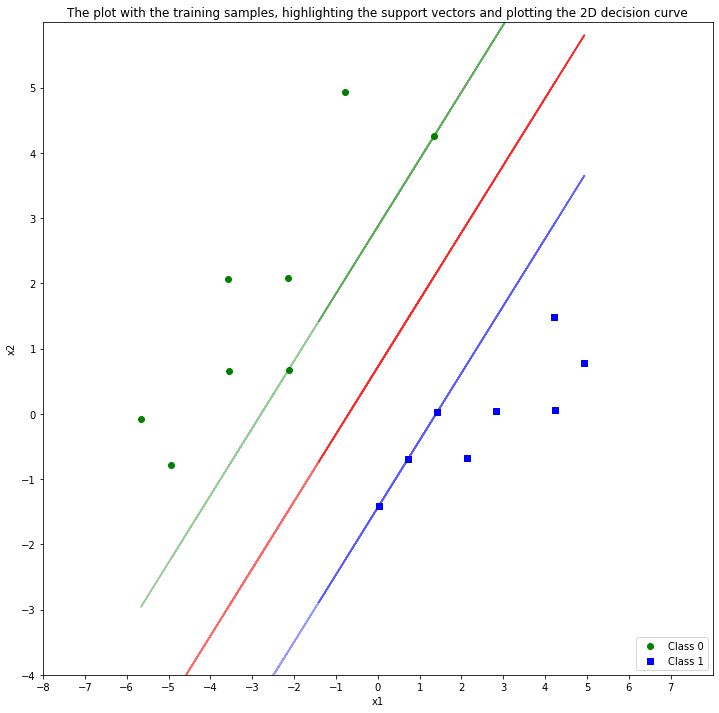

In [13]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='s', color='blue', 
            label='Class 1',)

# Plot the decision boundary and the margins using the optimized values of w and w0
plt.plot(X, (-w0.value - (w[0].value*X))/w[1].value , 'r', alpha=0.6)

# Plot the positive margin
plt.plot(X, (-w0.value - (w[0].value*X)+1)/w[1].value ,'b', alpha=0.4)

# Plot the negative margin
plt.plot(X, (-w0.value - (w[0].value*X)-1)/w[1].value , 'g', alpha=0.4)

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-4, 6)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-4, 6, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Add title
plt.title("The plot with the training samples, highlighting the support vectors and plotting the 2D decision curve")

# Show plot
plt.show()


Classification Map

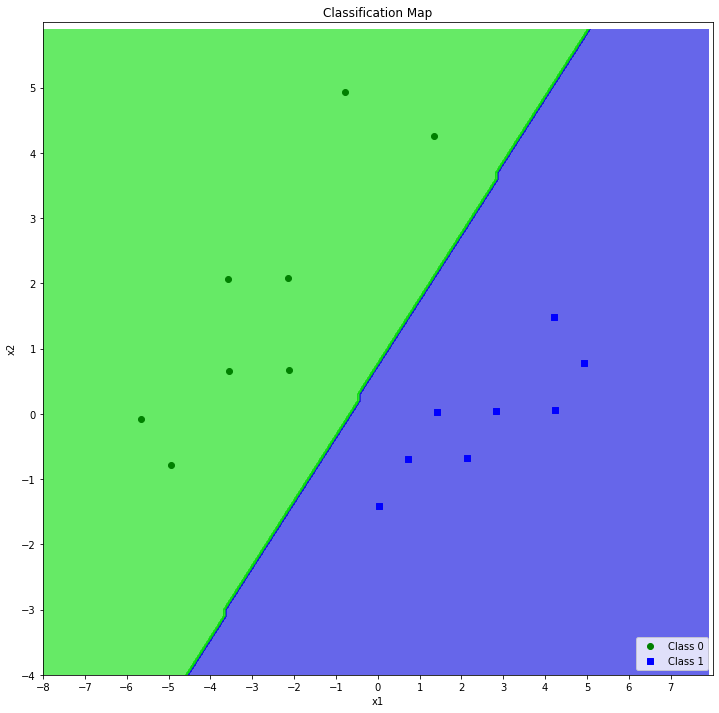

In [14]:
# Define step size for the mesh
h = 0.1

fig = plt.figure(figsize=(12, 12))

# Create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-8, 8, h), np.arange(-4, 6, h))

# Plot the decision boundary using the classifier function
Z = classify(w, w0, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
custom_map = ListedColormap(['#00DD', '#00DD00'])
plt.contourf(xx, yy, Z, cmap=custom_map, alpha=0.6)


# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='s', color='blue', 
            label='Class 1',)

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-4, 6)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-4, 6, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add title
plt.title("Classification Map")

# Add legend
plt.legend(loc='lower right')


plt.show()

## **c) Comparing the results with SVC**

In [15]:
N = X.shape[0]
svc = svm.SVC(C = 1e16, kernel = 'linear')
svc.fit(X, y)
sv = svc.support_vectors_
w_svm = svc.coef_.flatten()
w0_svm = svc.intercept_
print(w_svm)
print(w0_svm) 

[ 0.47843938 -0.46434148]
[0.33342206]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
# Get the support vectors
support_vectors = svc.support_vectors_

# Get the decision function
decision_function = svc.decision_function(support_vectors)

print("Support vectors: \n", support_vectors)
print("Decision function: \n", decision_function)

Support vectors: 
 [[-2.13173871  0.6750482 ]
 [ 1.35009641  4.26347742]
 [ 0.02131882 -1.41405287]
 [ 1.41405287  0.02131882]]
Decision function: 
 [-0.99993858 -1.00034807  1.00022522  1.00006142]


It is seen that support vectors returned by SVC are the same that we have calculated before:
* Found support vectors for class 2:  [[-2.131738708535863, 0.6750482045971622], [1.3500964091943244, 4.263477417071726]]
* Found support vectors for class 1:  [[0.021318818948875214, -1.41405286604095], [1.41405286604095, 0.021318818948875214]}





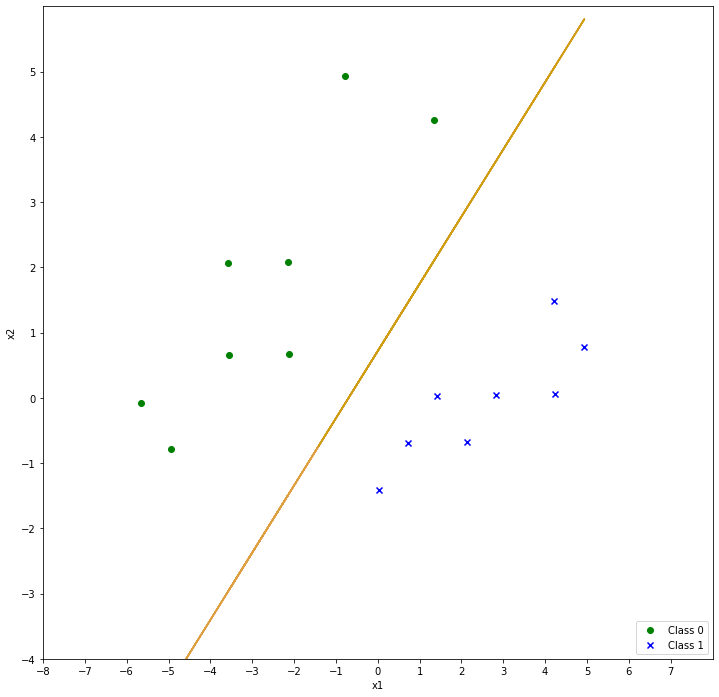

In [17]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Plot the decision boundary and the margins using the optimized values of w and w0
plt.plot(X, (-w0.value - (w[0].value*X))/w[1].value , 'r', alpha=0.5)
plt.plot(X, (-w0_svm - (w_svm[0]*X))/w_svm[1] , 'y', alpha=0.5)

# Set plot limits
plt.xlim(-8, 8)
plt.ylim(-4, 6)

# Set axis ticks
plt.xticks(np.arange(-8, 8, step=1))
plt.yticks(np.arange(-4, 6, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


It is seen that both support vectors returned by SVC and the corresponding decision function are almost identical.

# **T2**

In [18]:
ds2.loc[ds2[2] == 0, 2] = -1

In [19]:
# Load the data and labels
X = ds2[[0,1]].values
y = ds2[2].values

In [20]:
# Class 0 are negatives and Class 1 are positives
class_0 = ds2.loc[ds2[2] == -1]
class_1 = ds2.loc[ds2[2] == 1]

In [21]:
X_neg = class_0[[0,1]].values
X_pos = class_1[[0,1]].values

y_pos = class_0[2].values
y_neg = class_1[2].values

In [22]:
#Change classes to numpy
class_0 = class_0.to_numpy()
class_1 = class_1.to_numpy()

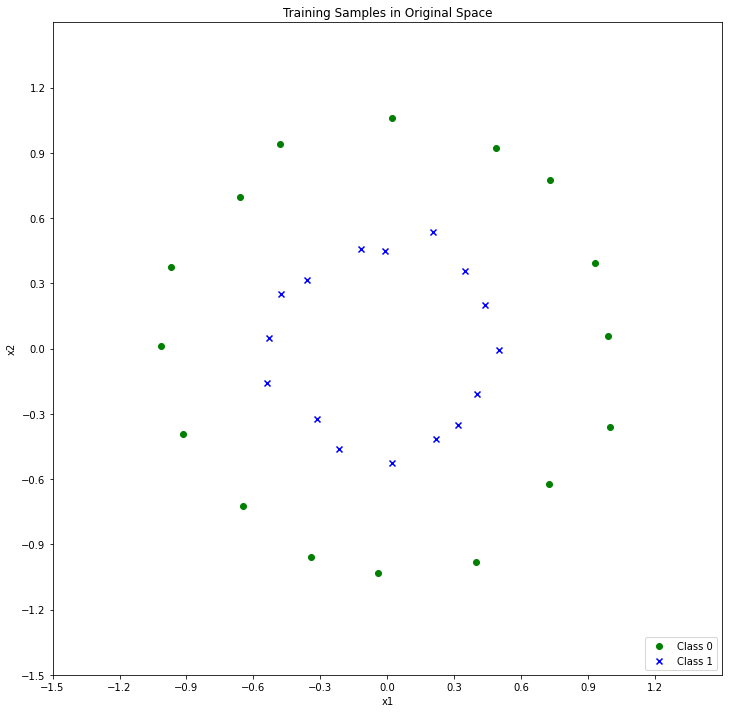

In [23]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Set plot limits
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

# Set axis ticks
plt.xticks(np.arange(-1.5, 1.5, step=0.3))
plt.yticks(np.arange(-1.5, 1.5, step=0.3))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add title
plt.title("Training Samples in Original Space")

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


Mapping the training samples to an alternative 2-dimensional space Φ(x)

Transformed Space:
$$
  Φ(x) = (x_{1}x_{2},x_{1}^2 + x_{2}^2)
$$ 

In [24]:
#positives
X1 = X_pos[:, 0].reshape((-1, 1))
X2 = X_pos[:, 1].reshape((-1, 1))
x1x2 = X1 * X2
x1x2sq = X1**2 + X2**2
X_pos_transformed = np.hstack((x1x2, x1x2sq))

#negatives
X1 = X_neg[:, 0].reshape((-1, 1))
X2 = X_neg[:, 1].reshape((-1, 1))
x1x2 = X1 * X2
x1x2sq = X1**2 + X2**2
X_neg_transformed = np.hstack((x1x2, x1x2sq))

Plotting the samples in the transformed space

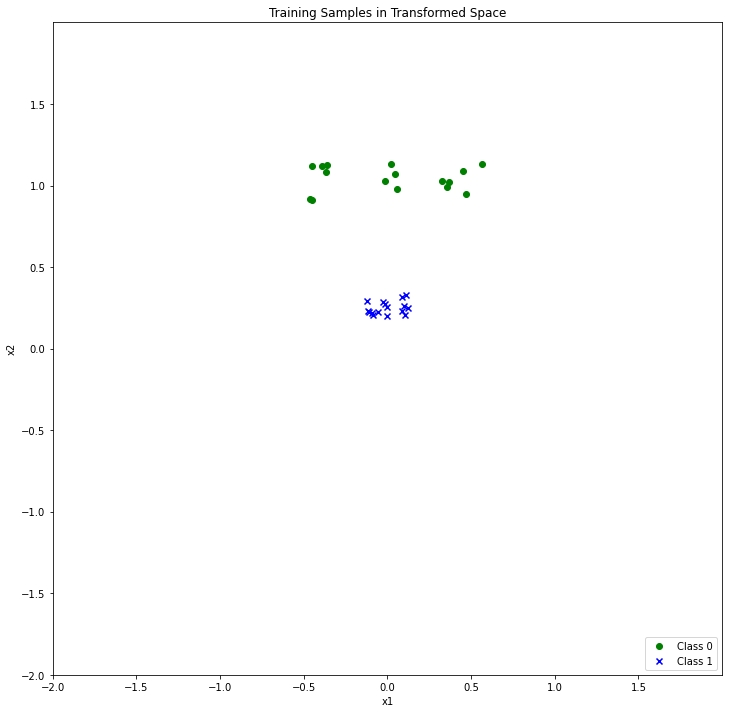

In [25]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(X_neg_transformed[:, 0], X_neg_transformed[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(X_pos_transformed[:, 0], X_pos_transformed[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Set plot limits
plt.xlim(-2, 2)
plt.ylim(-2, 2)

# Set axis ticks
plt.xticks(np.arange(-2, 2, step=0.5))
plt.yticks(np.arange(-2, 2, step=0.5))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add title
plt.title("Training Samples in Transformed Space")

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


## **a) Solve for the SVM with quadratic programming solver**

In [26]:
def kernel(x, y):
  return (1 + np.dot(x, y.T)) ** 3
     
N = X.shape[0]

P = np.empty((N,  N))

for i in range(N):
		for j in range(N):
			P[i, j] = y[i]*y[j]*kernel(X[i], X[j])
   
q = -np.ones((N,1))
G = -np.eye(N)
h = np.zeros((N, 1))
A = y.reshape((1, N))
b = np.zeros((1, 1))

# Convert to CVXOPT matrix format
P = matrix(P)
q = matrix(q)
G = matrix(G)
h = matrix(h)
A = matrix(A.astype('double'))
b = matrix(b)

# Solve Optimization Problem
sol = solvers.qp(P, q, G, h, A, b)
lambdas = np.array(sol['x']).reshape(N)


     pcost       dcost       gap    pres   dres
 0: -2.5704e+00 -7.5354e+00  5e+01  6e+00  1e+00
 1: -1.0516e+00 -7.3379e+00  6e+00  1e-15  7e-16
 2: -2.5155e+00 -3.3408e+00  8e-01  4e-16  5e-16
 3: -2.8999e+00 -3.1904e+00  3e-01  3e-16  5e-16
 4: -3.0264e+00 -3.0623e+00  4e-02  6e-16  7e-16
 5: -3.0460e+00 -3.0471e+00  1e-03  4e-16  8e-16
 6: -3.0467e+00 -3.0468e+00  4e-05  3e-16  6e-16
 7: -3.0468e+00 -3.0468e+00  4e-07  5e-16  6e-16
Optimal solution found.


In [27]:
lambdas

array([5.70971723e-08, 1.80531919e-01, 1.66883889e-05, 2.04322048e-08,
       3.12441699e-08, 1.45180691e-08, 1.84746747e-08, 2.57313535e-08,
       7.48888174e-01, 1.94165148e-08, 6.29678150e-09, 1.24970092e+00,
       1.99041307e-08, 6.15667018e-01, 3.15257331e-08, 2.56155495e-08,
       1.91988995e-08, 3.29624488e-08, 1.58371335e-08, 1.18138387e+00,
       5.75180670e-01, 7.93981166e-09, 2.01513715e-08, 7.95648431e-08,
       5.95848775e-09, 2.58293512e-07, 5.49817681e-01, 1.53400570e-01,
       3.94075701e-08, 5.28927581e-08, 2.20836551e-08, 8.38916139e-01])

In [28]:
SV = np.where(lambdas > 1e-4)[0][0]
w_org = np.array([0, 0])
for lm, y_i, x_i in zip(lambdas, y, X):
           cur_i = lm * y_i * x_i
           w_org = np.add(w_org, cur_i)
w0_org = y[SV] - sum(lambdas * y * kernel(X, X[SV]))
# Print the values of the optimized variables
print(w_org, w0_org) 

[-0.03706209  0.05087745] 1.8857837012704088


### **a.1) Report the support vectors in the original space**

In [29]:
support_vectors_indices = np.where(lambdas > 1e-4)[0]
support_vectors = []
for i in range(N):
  if i in support_vectors_indices:
    support_vectors.append(X[i])
support_vectors = np.array(support_vectors)

print("Support vectors indices: ", support_vectors_indices)
print("Support vectors in the original space:")
print(support_vectors)

Support vectors indices:  [ 1  8 11 13 19 20 26 27 31]
Support vectors in the original space:
[[ 0.93177858  0.39247832]
 [-0.65965904  0.69641677]
 [ 0.20615067  0.53764932]
 [ 0.02155068 -0.52469778]
 [-0.53995339 -0.15720944]
 [ 0.48751958  0.92202874]
 [ 0.72494518 -0.62098264]
 [-0.91519216 -0.39227158]
 [-0.64694443 -0.72577596]]


### **a.2) calculate and report the resulting decision functions**

Mapping the training samples to an alternative 2-dimensional space Φ(x)

Transformed Space:
$$
  Φ(x) = (x_{1}x_{2},x_{1}^2 + x_{2}^2)
$$ 

In [30]:
X1 = X[:, 0].reshape((-1, 1))
X2 = X[:, 1].reshape((-1, 1))
x1x2 = X1 * X2
x1x2sq = X1**2 + X2**2
X_transformed = np.hstack((x1x2, x1x2sq))

In [31]:
# N is the number of rows in the data matrix X
N = X_transformed.shape[0]

# Reshape y to match the shape of X
y = y.reshape((N,1))

# Create variables for the weights and bias
w = cp.Variable((2,1))
w0 = cp.Variable()

# Define the loss function as the L2 norm of w squared, which is equivalent to the L2 regularization
loss = cp.Minimize(0.5 * cp.square(cp.norm(w)))

# Create an empty list to store the constraints
constr = []

# Iterate through each data point and add a constraint for it
for i in range(N):
  xi, yi = X_transformed[i,:], y[i]
  constr += [yi @ (xi @ w + w0) >= 1]

# Create the optimization problem with the loss and constraints
prob = cp.Problem(loss, constr)

# Solve the problem
prob.solve()

# Print the values of the optimized variables
print(w.value, w0.value) # w = [1.0, -1.0], w0 = -1.0

[[ 0.12358649]
 [-3.33103156]] 2.090755204584221


Decision Funtion in the transformed space:
$$
  g(x') = 0.1235x'_{1} - 3.331x'_{2} + 2.0907
$$ 

In [32]:
print(w_org, w0_org) 

[-0.03706209  0.05087745] 1.8857837012704088


Decision Funtion in the original space:
$$
  g_2(x') = -0.037Φ(x'_{1}) + 0.0508Φ(x'_{2}) + 1.8857
$$ 

## **b) Generate the plots**

The plot with the training samples, highlighting the support vectors in ***transformed space***

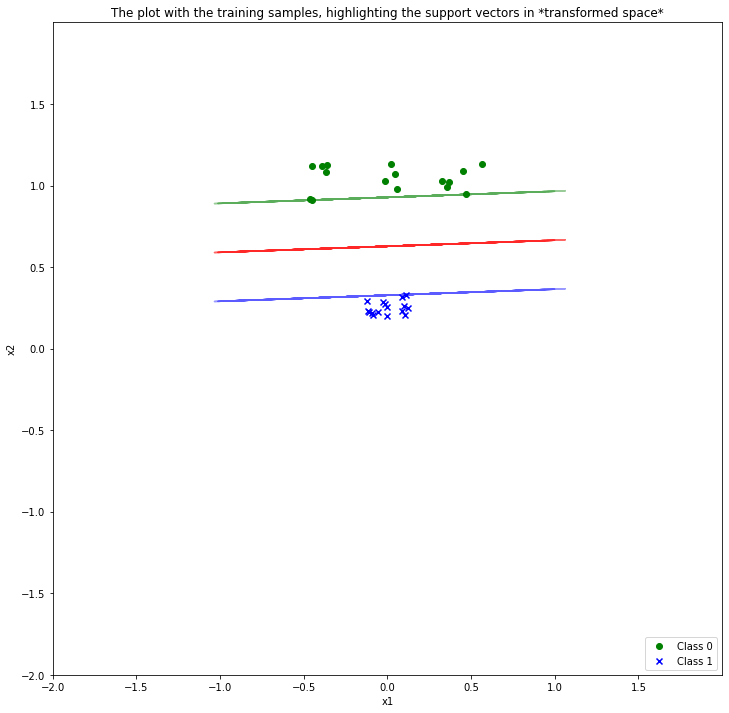

In [33]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(X_neg_transformed[:, 0], X_neg_transformed[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(X_pos_transformed[:, 0], X_pos_transformed[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Plot the decision boundary and the margins using the optimized values of w and w0
plt.plot(X, (-w0.value - (w[0].value*X))/w[1].value , 'r', alpha=0.6)

# Plot the positive margin
plt.plot(X, (-w0.value - (w[0].value*X)+1)/w[1].value ,'b', alpha=0.4)

# Plot the negative margin
plt.plot(X, (-w0.value - (w[0].value*X)-1)/w[1].value , 'g', alpha=0.4)

# Set plot limits
plt.xlim(-2, 2)
plt.ylim(-2, 2)

# Set axis ticks
plt.xticks(np.arange(-2, 2, step=0.5))
plt.yticks(np.arange(-2, 2, step=0.5))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add title
plt.title("The plot with the training samples, highlighting the support vectors in *transformed space*")

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


The plot with the training samples, highlighting the decision curve in ***original space***

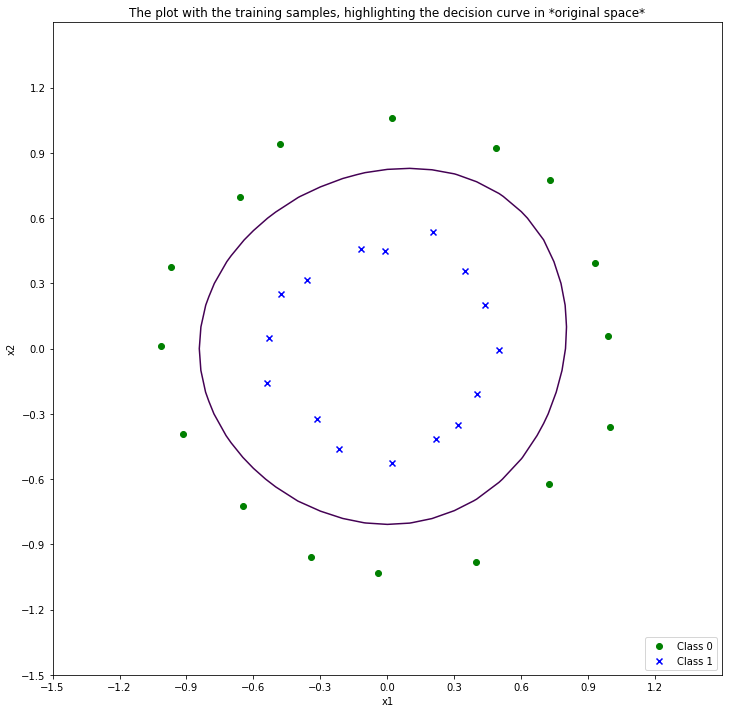

In [34]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

h = 0.1
# Create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-3, 3, h), np.arange(-3, 3, h))

# Concatenate the xx and yy values
d = np.concatenate((xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)), axis=1)

# Compute the Z values for the contour plot
Z = b + np.sum(lambdas.reshape((N, 1)) * y. reshape((N, 1)) * kernel(X, d), axis=0)
Z = Z.reshape(xx.shape)

# Plot the decision boundar
plt.contour(xx, yy, Z, levels=[-2])

# Set plot limits
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

# Set axis ticks
plt.xticks(np.arange(-1.5, 1.5, step=0.3))
plt.yticks(np.arange(-1.5, 1.5, step=0.3))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add title
plt.title("The plot with the training samples, highlighting the decision curve in *original space*")

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


the classification map in the original space

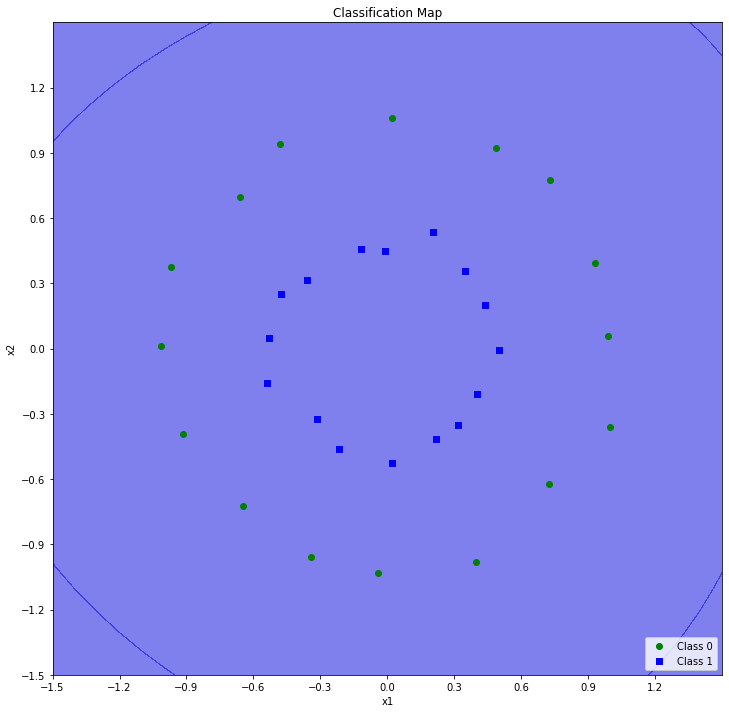

In [35]:
# Define step size for the mesh
h = 0.1

fig = plt.figure(figsize=(12, 12))

# Create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-3, 3, h), np.arange(-3, 3, h))

# Plot the decision boundary using the classifier function
custom_map = ListedColormap(['#00DD00', '#00DD'])
plt.contourf(xx, yy, Z, cmap=custom_map, alpha=0.5)


# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='s', color='blue', 
            label='Class 1',)

# Set plot limits
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

# Set axis ticks
plt.xticks(np.arange(-1.5, 1.5, step=0.3))
plt.yticks(np.arange(-1.5, 1.5, step=0.3))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add title
plt.title("Classification Map")

# Add legend
plt.legend(loc='lower right')


plt.show()

## **c) Comparing the results with SVC**

In [38]:
from sklearn.svm import SVC
# get gram matrix 
n_samples = X.shape[0]
gram_matrix = np.empty((n_samples, n_samples))

# fill the gram matrix with kernel values 
for i in range(n_samples):
    for j in range(n_samples):
        gram_matrix[i, j] = kernel(X[i], X[j])


# convert y values to -1 and 1 
for idx in range(len(y)):
    if y[idx][0] == 0: 
        y[idx] = [-1]

# create an array of 1's and 0's corresponding to y values 
hue_y = []
for idx in range(len(y)):
    if y[idx] == -1: 
        hue_y.append(0)
    else: 
        hue_y.append(1)

# to force a perfect classification of the training set
c_val = 1e12

# create SVC classifier with precomputed kernel and regularization parameter 
clf = SVC(kernel='precomputed', C=c_val)
clf.fit(gram_matrix, y.ravel())

# get support vectors and decision function 
support_vectors = clf.support_
w0 = clf.intercept_
decision_function = clf.decision_function(gram_matrix)

# get dual coefficients 
lmi_yi = clf.dual_coef_

# calculate lambda * yi for corresponding support vectors 
lm_arr = np.zeros(n_samples)
for cur_sv, cur_lmi_yi in zip(support_vectors, lmi_yi.ravel()):
    lmi = cur_lmi_yi * y.ravel()[cur_sv]
    lm_arr[cur_sv] = lmi

# reshape lambda array 
lm_arr = lm_arr.reshape(-1, 1)

# calculate w 
w = sum(lm_arr * y * X)

# printing the support vectors 
print("Support vectors  from the scikit-learn SVC :")
print(X[support_vectors])

# print w and w0 values 
print("The values of w from the scikit-learn SVC:", w)
print("The value of w0 from the scikit-learn SVC ", w0[0])


Support vectors  from the scikit-learn SVC :
[[ 0.93177858  0.39247832]
 [-0.65965904  0.69641677]
 [ 0.48751958  0.92202874]
 [ 0.72494518 -0.62098264]
 [-0.91519216 -0.39227158]
 [-0.64694443 -0.72577596]
 [ 0.20615067  0.53764932]
 [ 0.02155068 -0.52469778]
 [-0.53995339 -0.15720944]]
The values of w from the scikit-learn SVC: [-0.03640866  0.05079516]
The value of w0 from the scikit-learn SVC  1.8863233063548297


Comparing previous values

In [117]:
print(w_org, w0_org) 

[-0.03706209  0.05087745] 1.8857837012704088


Decision Funtion:
$$
  g_2(x') = -0.0364Φ(x'_{1}) + 0.05079Φ(x'_{2}) + 1.8863
$$ 

They are almost the same!

## **d) Comparing the results with SVC for 'rbf' kernal**

In [40]:
from sklearn.svm import SVC
# get gram matrix 
n_samples = X.shape[0]
gram_matrix = np.empty((n_samples, n_samples))

# fill the gram matrix with kernel values 
for i in range(n_samples):
    for j in range(n_samples):
        gram_matrix[i, j] = kernel(X[i], X[j])


# convert y values to -1 and 1 
for idx in range(len(y)):
    if y[idx][0] == 0: 
        y[idx] = [-1]

# create an array of 1's and 0's corresponding to y values 
hue_y = []
for idx in range(len(y)):
    if y[idx] == -1: 
        hue_y.append(0)
    else: 
        hue_y.append(1)

# to force a perfect classification of the training set
c_val = 1e12

# create SVC classifier with precomputed kernel and regularization parameter 
clf = SVC(kernel='rbf', C=c_val, gamma=1)
clf.fit(gram_matrix, y.ravel())

# get support vectors and decision function 
support_vectors = clf.support_
w0 = clf.intercept_
decision_function = clf.decision_function(gram_matrix)

# get dual coefficients 
lmi_yi = clf.dual_coef_

# calculate lambda * yi for corresponding support vectors 
lm_arr = np.zeros(n_samples)
for cur_sv, cur_lmi_yi in zip(support_vectors, lmi_yi.ravel()):
    lmi = cur_lmi_yi * y.ravel()[cur_sv]
    lm_arr[cur_sv] = lmi

# reshape lambda array 
lm_arr = lm_arr.reshape(-1, 1)

# calculate w 
w = sum(lm_arr * y * X)

# printing the support vectors 
print("Support vectors  from the scikit-learn SVC :")
print(X[support_vectors])

# print w and w0 values 
print("The values of w from the scikit-learn SVC:", w)
print("The value of w0 from the scikit-learn SVC ", w0[0])


Support vectors  from the scikit-learn SVC :
[[ 0.93177858  0.39247832]
 [-1.01283459  0.01326375]
 [-0.34062917 -0.95604755]
 [ 0.98776486  0.05650065]
 [-0.65965904  0.69641677]
 [-0.47999076  0.94241591]
 [-0.96836378  0.37747135]
 [ 0.397968   -0.98043212]
 [ 0.48751958  0.92202874]
 [ 0.02136256  1.06287645]
 [ 0.99945165 -0.35971565]
 [ 0.72828234  0.77402887]
 [ 0.72494518 -0.62098264]
 [-0.91519216 -0.39227158]
 [-0.04255727 -1.03348659]
 [-0.64694443 -0.72577596]
 [ 0.50225699 -0.0040131 ]
 [ 0.21613659 -0.41421755]
 [-0.0116211   0.44752944]
 [ 0.34658016  0.35554526]
 [ 0.43872323  0.200325  ]
 [ 0.20615067  0.53764932]
 [-0.1195835   0.45827011]
 [ 0.02155068 -0.52469778]
 [-0.53001393  0.04941238]
 [ 0.40192782 -0.20891975]
 [-0.31753332 -0.32292457]
 [-0.53995339 -0.15720944]
 [-0.36191934  0.31487637]
 [-0.21505056 -0.46066945]
 [ 0.31598159 -0.35227077]
 [-0.47733448  0.25234365]]
The values of w from the scikit-learn SVC: [-0.34078459 -0.06121092]
The value of w0 from 

When using rbf, there are more support vectors

# **T3**

In [ ]:
ds3tr.loc[ds3tr[2] == 0, 2] = -1
ds3te.loc[ds3te[2] == 0, 2] = -1

In [ ]:
#Train and test
X_train = ds3tr.drop(columns=[2])
y_train = ds3tr[2]

X_test = ds3te.drop(columns=[2])
y_test = ds3te[2]

In [ ]:
# Class 0 are negatives and Class 1 are positives
class_0 = ds3tr.loc[ds3tr[2] == -1]
class_1 = ds3tr.loc[ds3tr[2] == 1]

class_0 = class_0.to_numpy()
class_1 = class_1.to_numpy()

plotting the samples

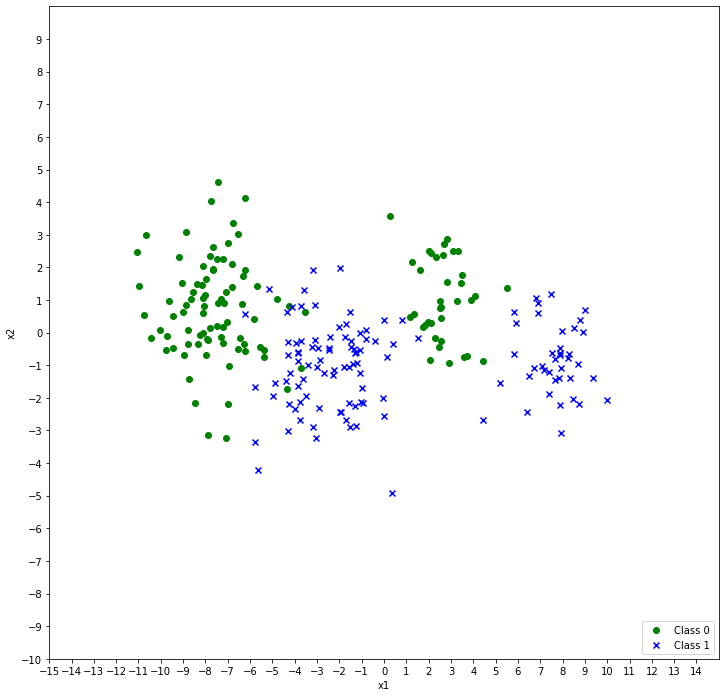

In [ ]:
# Plot
fig = plt.figure(figsize=(12, 12))

# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='x', color='blue', 
            label='Class 1')

# Set plot limits
plt.xlim(-15, 15)
plt.ylim(-10, 10)

# Set axis ticks
plt.xticks(np.arange(-15, 15, step=1))
plt.yticks(np.arange(-10, 10, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.show()


## **a, b) hyper-parameters tuning and the best performing classifier**

5 cross-validation using accuracy as a metric

In [ ]:
knn = KNeighborsClassifier()
params = [{'n_neighbors': [3,5,7,9],'metric': ['euclidean', 'manhattan','cityblock','minkowski']}]

gs_knn = GridSearchCV(knn,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5) # 5 cross-validation
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 7}

Best distance metric is manhattan and the best value for number og neighbors is 7

In [ ]:
gs_knn

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['euclidean', 'manhattan', 'cityblock',
                                     'minkowski'],
                          'n_neighbors': [3, 5, 7, 9]}],
             scoring='accuracy')

The best accuracy score is shown 

In [ ]:
# Printing top performing accuracy score
print("The best accuracy score: ", gs_knn.best_score_)

The best accuracy score:  0.9583333333333334


Training knn with best params

In [ ]:
knn = KNeighborsClassifier(metric='manhattan',n_neighbors=7)

knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)

## **c) Plot the training samples on classification map**

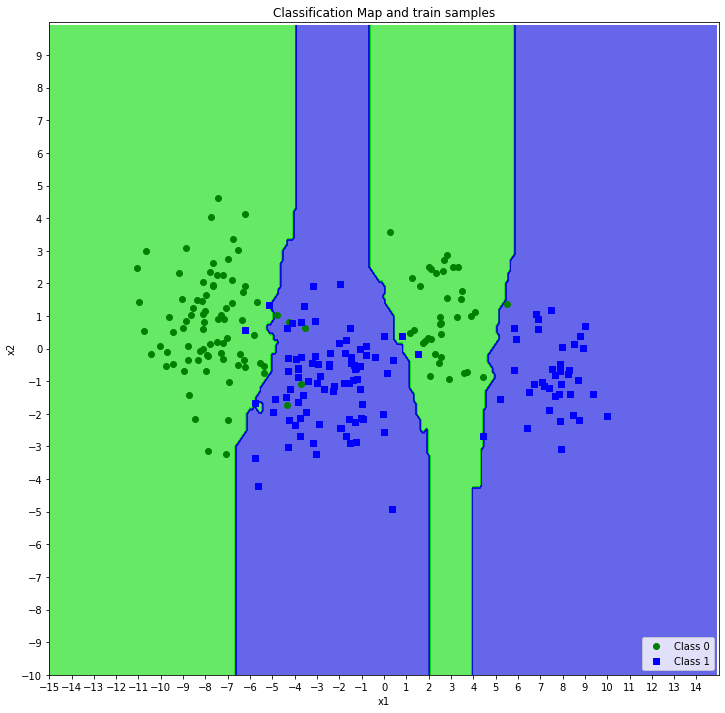

In [ ]:
# Define step size for the mesh
h = 0.1

fig = plt.figure(figsize=(12, 12))

# Create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-15, 15, h), np.arange(-10, 10, h))

# Plot the decision boundary using the classifier function
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
custom_map = ListedColormap(['#00DD00', '#00DD'])
plt.contourf(xx, yy, Z, cmap=custom_map, alpha=0.6)


# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='s', color='blue', 
            label='Class 1',)

# Set plot limits
plt.xlim(-15, 15)
plt.ylim(-10, 10)

# Set axis ticks
plt.xticks(np.arange(-15, 15, step=1))
plt.yticks(np.arange(-10, 10, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add title
plt.title("Classification Map and train samples")

# Add legend
plt.legend(loc='lower right')


plt.show()

## **d) Reporting on the classifier performance using the test dataset**

In [ ]:
# use the trained model to make predictions on the test data set
y_pred = knn.predict(X_test) 

In [ ]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("Test accuracy: ", test_accuracy)
print("Test precision: ", test_precision)
print("Test recall: ", test_recall)
print("Test f1-score: ", test_f1)

Test accuracy:  0.9666666666666667
Test precision:  0.9333333333333333
Test recall:  1.0
Test f1-score:  0.9655172413793104


In [ ]:
print(classification_report(y_test, y_pred)) # evaluate the model's performance using a classification report

print("ROC AUC score: ",roc_auc_score(y_test, y_pred)) # check the performance of the model using ROC score.

              precision    recall  f1-score   support

        -1.0       1.00      0.94      0.97        32
         1.0       0.93      1.00      0.97        28

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60

ROC AUC score:  0.96875


In [ ]:
# Class 0 are negatives and Class 1 are positives
class_0 = ds3te.loc[ds3te[2] == -1]
class_1 = ds3te.loc[ds3te[2] == 1]

class_0 = class_0.to_numpy()
class_1 = class_1.to_numpy()

Plotting the test samples over the already calculated classification map

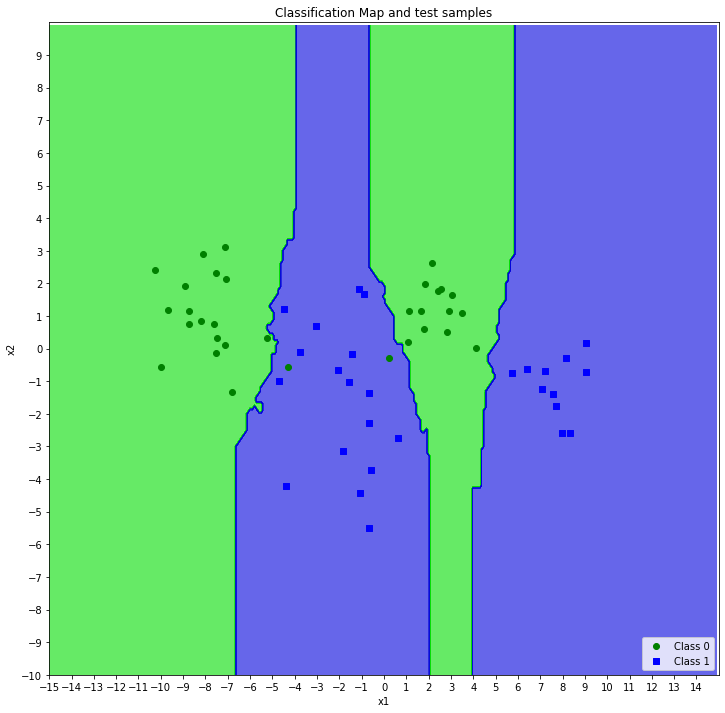

In [ ]:
# Define step size for the mesh
h = 0.1

fig = plt.figure(figsize=(12, 12))

# Create a mesh to plot in
xx, yy = np.meshgrid(np.arange(-15, 15, h), np.arange(-10, 10, h))

# Plot the decision boundary using the classifier function
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
custom_map = ListedColormap(['#00DD00', '#00DD'])
plt.contourf(xx, yy, Z, cmap=custom_map, alpha=0.6)


# Scatter plot for class 0
plt.scatter(class_0[:, 0], class_0[:, 1], 
            marker='o', color='green', 
            label='Class 0')

# Scatter plot for class 1
plt.scatter(class_1[:, 0], class_1[:, 1], 
            marker='s', color='blue', 
            label='Class 1',)

# Set plot limits
plt.xlim(-15, 15)
plt.ylim(-10, 10)

# Set axis ticks
plt.xticks(np.arange(-15, 15, step=1))
plt.yticks(np.arange(-10, 10, step=1))

# Set axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add labels
plt.xlabel('x1')
plt.ylabel('x2')

# Add title
plt.title("Classification Map and test samples")

# Add legend
plt.legend(loc='lower right')

plt.show()

## **e) Obtain an improved estimation**

In [ ]:
# specifying the evaluation metrics
scoring = {'Accuracy': 'accuracy',
           'Precision': make_scorer(precision_score, average='binary'),
           'Recall': make_scorer(recall_score, average='binary'),
           'F1': make_scorer(f1_score, average='binary')}

# creating the cross-validation using 3-repetition, 5-fold 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=14659232)

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

scores = cross_validate(knn, X, y, scoring=scoring, cv=cv, n_jobs=-1)

for metric in scoring:
  mean = np.mean(scores['test_' + metric])
  std = np.std(scores['test_' + metric])
  print(f'{metric}: {mean:.4f} (+/- {std * 2:.4f})')
print()

Accuracy: 0.9511 (+/- 0.0463)
Precision: 0.9422 (+/- 0.0656)
Recall: 0.9622 (+/- 0.0479)
F1: 0.9518 (+/- 0.0454)

